# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [1]:
# Don’t worry about this. This is needed to interpret the Python code that is embedded in the data set. You only need it literally in the very next code cell and nowhere else. 
from ast import literal_eval

# The rest is just the stuff from the lecture.
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [2]:
rules_data_path = 'data/rules.tsv.xz'                       # You do not need to decompress this yourself. Pandas understands how to read compressed data.

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,                           # This disables interpretation of quotes by Pandas itself, because both single and double quotes will be resolved by literal_eval.
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval # This reads something like ["Grandma's 8\" Chip Cookies", '6" Apple Pie'] into a list, so you will get a column where each individual cell is a list.
                       },
                       low_memory=True)                     # For Chris

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


But just *how* many rules were just loaded‽

In [9]:
# Show the list of column names and the number of rules.
# Display the column names
print("Column names:", df_rules.columns.tolist())

# Display the number of rules (rows)
print("Number of rules:", len(df_rules))




Column names: ['consequent_item', 'transaction_count', 'item_set_count', 'antecedent_count', 'consequent_count', 'antecedent_items', 'support', 'confidence', 'lift']
Number of rules: 1048575
1048575


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [11]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

total_transactions = 1048575 

# Function to calculate support, confidence, and lift
def calculate_support_confidence_lift(df, total_transactions):
    df['antecedent_count'] = df['antecedent_items'].apply(lambda x: len(set(x)))
    df['consequent_count'] = df['consequent_item'].apply(lambda x: len(set(x)))
    df['item_set_count'] = df.apply(lambda row: len(set(row['antecedent_items']).union(set(row['consequent_item']))), axis=1)
    df['support'] = df['item_set_count'] / total_transactions
    df['confidence'] = df['item_set_count'] / df['antecedent_count']
    df['lift'] = (df['item_set_count'] * total_transactions) / (df['antecedent_count'] * df['consequent_count'])
    return df

df_rules = calculate_support_confidence_lift(df_rules, total_transactions)
df_rules[['antecedent_items', 'consequent_item', 'support', 'confidence', 'lift']].head(50)

,antecedent_items,consequent_item,support,confidence,lift
0,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",Total 2% with Raspberry Pomegranate Lowfat Gre...,0.000031,11.000000,384477.500000
1,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",Total 2% Lowfat Greek Strained Yogurt With Blu...,0.000030,7.750000,300979.861111
2,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",Total 0% with Honey Nonfat Greek Strained Yogurt,0.000027,9.333333,391468.000000
3,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",Total 0% Raspberry Yogurt,0.000020,7.000000,407779.166667
4,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",Pineapple Yogurt 2%,0.000019,5.000000,327679.687500
5,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",Fat Free Strawberry Yogurt,0.000016,5.666667,424423.214286
6,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",Fat Free Blueberry Yogurt,0.000017,4.500000,337041.964286
7,"[Blackberry Yogurt, Fat Free Strawberry Yogurt...",Total 2% with Raspberry Pomegranate Lowfat Gre...,0.000032,8.500000,297096.250000
8,"[Blackberry Yogurt, Fat Free Strawberry Yogurt...",Total 2% Lowfat Greek Strained Yogurt With Blu...,0.000030,7.750000,300979.861111
9,"[Pineapple Yogurt 2%, Total 0% Raspberry Yogur...",Total 2% Greek Strained Yogurt with Cherry 5.3 oz,0.000030,7.750000,300979.861111


The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

Lift measures the degree of association between the antecedent and consequent. A lift of 1 means the rule has no association (the two items occur together just as often as they would by chance). A lift greater than 1 means that the rule has a positive association (the items occur together more frequently than by chance). A very high lift (e.g., > 1000) suggests the rule is highly predictive of the consequent, but only if it occurs in very specific cases—which is why the support can be low, but the lift still high.

In [15]:
# Query the rule set if you have to to find out more.

df_infinite_lift = df_rules[df_rules['lift'] == float('inf')]# Query to see the rules with infinite lift values

df_infinite_lift.head()



,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
1033474,Banana,3346083,3,0,3,[],0.000003,inf,inf
1033475,Bag of Organic Bananas,3346083,12,0,12,[],0.000011,inf,inf
1033476,Organic Strawberries,3346083,14,0,14,[],0.000013,inf,inf
1033477,Organic Baby Spinach,3346083,14,0,14,[],0.000013,inf,inf
1033478,Organic Hass Avocado,3346083,14,0,14,[],0.000013,inf,inf


## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [21]:
# Step 1: Filter for rules with exactly 1 antecedent item
df_rules_1_antecedent = df_rules[df_rules['antecedent_items'].apply(len) == 1]

# Adjust the lift filter to include a broader range
df_rules_1_antecedent_filtered_lift = df_rules_1_antecedent[
    (df_rules_1_antecedent['lift'] >= 166024)  # Setting the minimum lift to the lowest in the dataset
]
# Step 3: Convert the antecedent_items list to a string (as there is only 1 antecedent item in this subset)
df_rules_1_antecedent_filtered_lift['antecedent_item'] = df_rules_1_antecedent_filtered_lift['antecedent_items'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Step 4: Filter for rules where either the antecedent or consequent contains 'Hummus', but not both
# Check if 'Hummus' is present in the updated filtered rules
df_rules_hummus_subset = df_rules_1_antecedent_filtered_lift[
    ((df_rules_1_antecedent_filtered_lift['antecedent_item'].str.contains('Hummus', case=False)) & 
     (~df_rules_1_antecedent_filtered_lift['consequent_item'].str.contains('Hummus', case=False))) |
    ((~df_rules_1_antecedent_filtered_lift['antecedent_item'].str.contains('Hummus', case=False)) & 
     (df_rules_1_antecedent_filtered_lift['consequent_item'].str.contains('Hummus', case=False)))
]


# Step 5: Replace any antecedent or consequent item containing 'Hummus' with just 'Hummus'
df_rules_hummus_subset['antecedent_item'] = df_rules_hummus_subset['antecedent_item'].apply(lambda x: 'Hummus' if 'Hummus' in x else x)
df_rules_hummus_subset['consequent_item'] = df_rules_hummus_subset['consequent_item'].apply(lambda x: 'Hummus' if 'Hummus' in x else x)

# Display the resulting subset of rules
print(f"Final subset size: {df_rules_hummus_subset.shape[0]}")
df_rules_hummus_subset.head()  # Show the first few rows to understand the results




Final subset size: 208


C:\Users\user\AppData\Local\Temp\ipykernel_10224\1493891542.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules_hummus_subset['antecedent_item'] = df_rules_hummus_subset['antecedent_item'].apply(lambda x: 'Hummus' if 'Hummus' in x else x)
C:\Users\user\AppData\Local\Temp\ipykernel_10224\1493891542.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rules_hummus_subset['consequent_item'] = df_rules_hummus_subset['consequent_item'].apply(lambda x: 'Hummus' if 'Hummus' in x else x)


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift,antecedent_item
257368,Snack Pack Classic Original Hommus With Chips,3346083,23,1,22,[Roasted Red Pepper Hummus With Chips],0.000022,23.0,1.096238e+06,Hummus
257369,Hummus,3346083,19,1,18,[Snack Pack Classic Original Hommus With Chips],0.000018,19.0,1.106829e+06,Snack Pack Classic Original Hommus With Chips
349099,Organic Simply Naked Pita Chips,3346083,23,1,22,[Organic Classic Hummus],0.000022,23.0,1.096238e+06,Hummus
351117,Hummus,3346083,16,1,15,[Smoked Whitefish Salad],0.000015,16.0,1.118480e+06,Smoked Whitefish Salad
354683,Hummus,3346083,11,1,10,[Pita Crisps Simply Naked],0.000010,11.0,1.153432e+06,Pita Crisps Simply Naked


Build a network `graph_rules_subset` from the association rules subset.

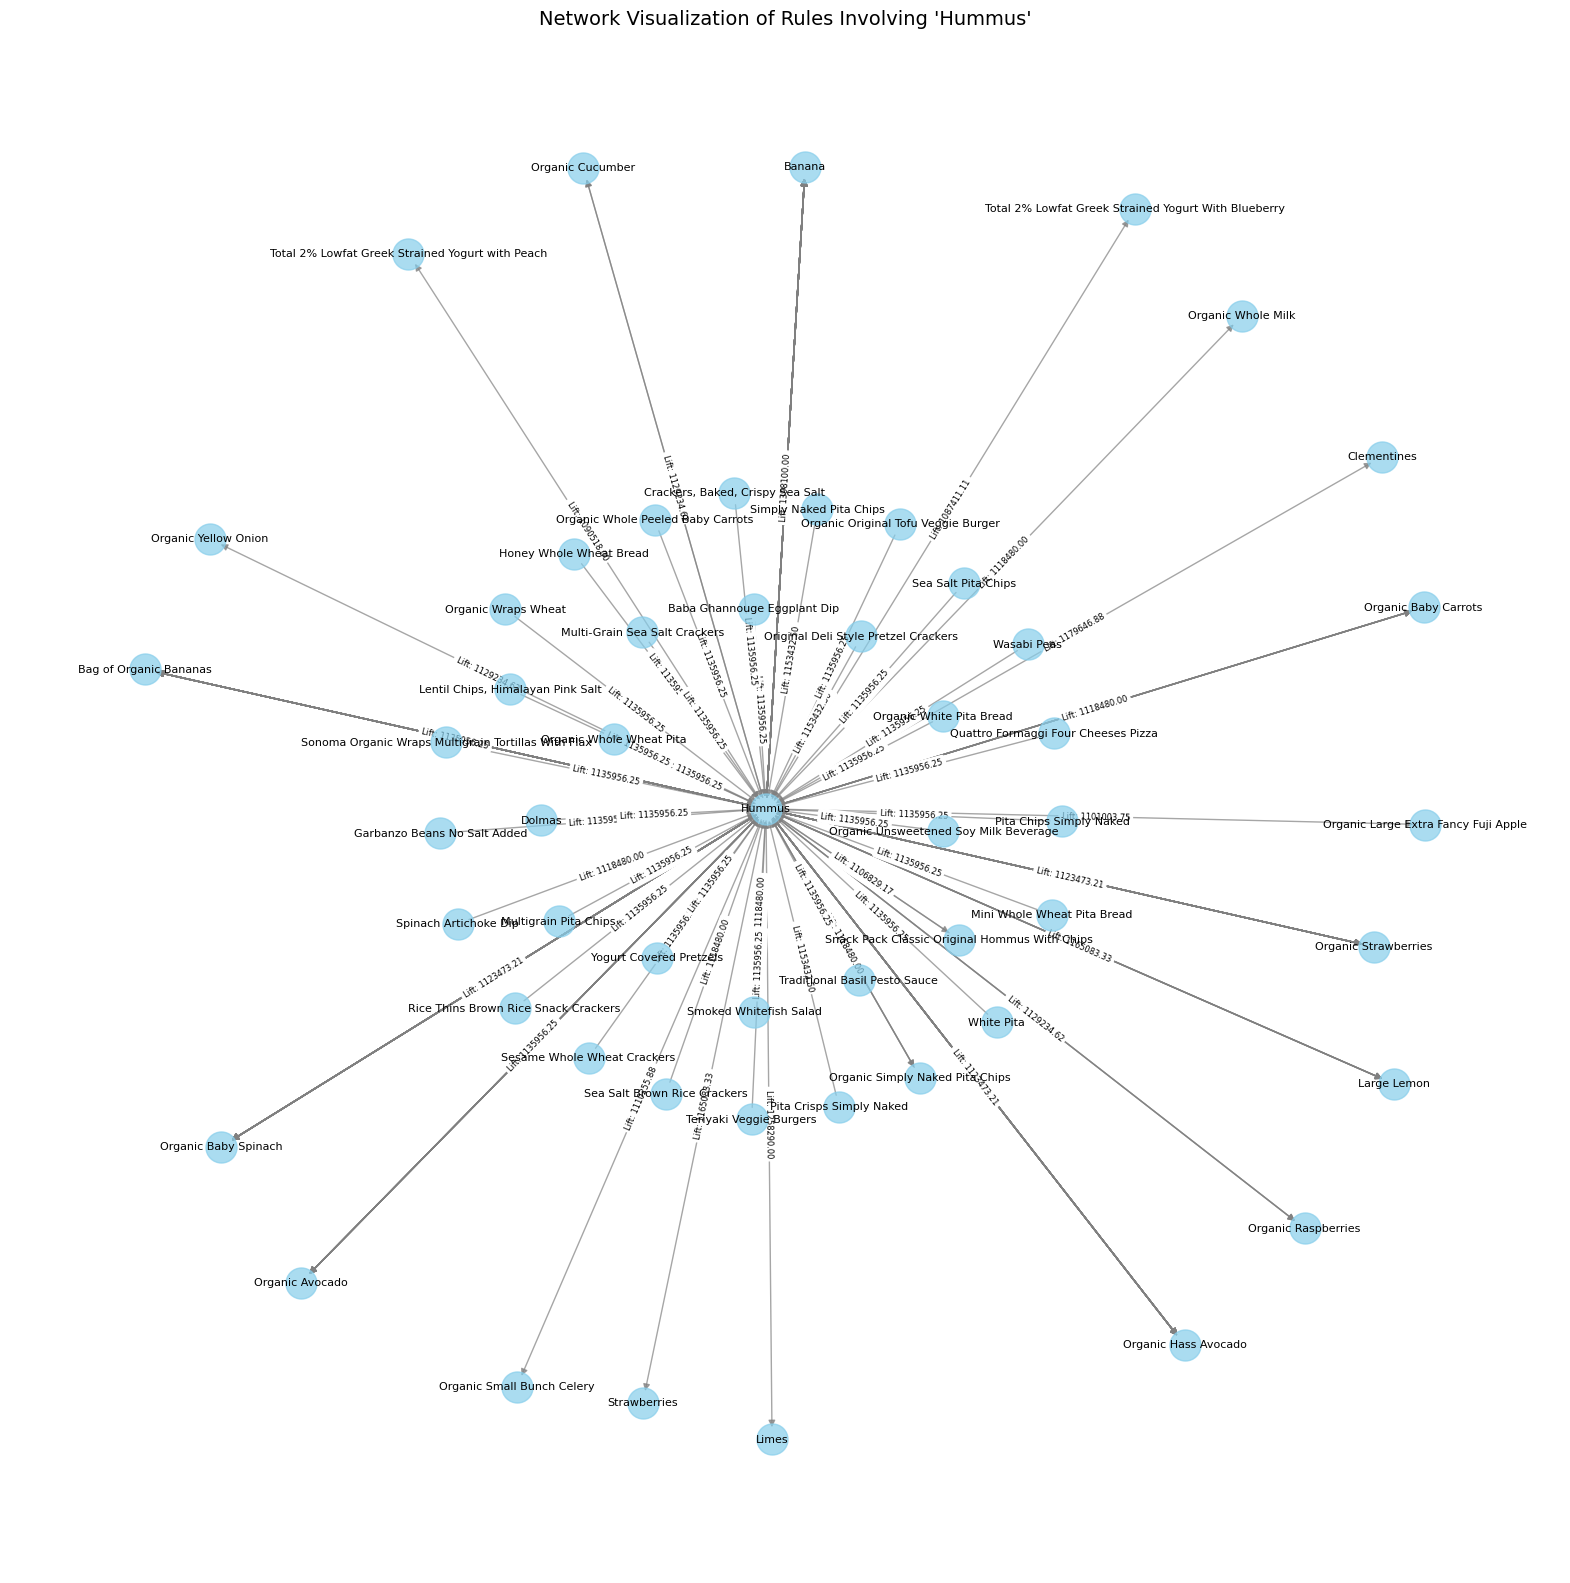

In [24]:
graph_rules_subset = nx.MultiDiGraph()

# Add edges to the graph from the subset
edges = [
    (row['antecedent_item'], row['consequent_item'], {
        'lift': row['lift'], 'confidence': row['confidence'], 'support': row['support']
    })
    for _, row in df_rules_hummus_subset.iterrows()
]

graph_rules_subset.add_edges_from(edges)

# Plot the graph with custom settings
plt.figure(figsize=(20, 20))  # Increase the figure size
pos = nx.spring_layout(graph_rules_subset, k=0.5, iterations=50)  # Spring layout for better spacing

# Draw the nodes and edges with styling
nx.draw_networkx_nodes(graph_rules_subset, pos, node_size=500, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(graph_rules_subset, pos, edgelist=edges, arrowstyle='-|>', arrowsize=10, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(graph_rules_subset, pos, font_size=8, font_color='black')

# Add edge labels for 'lift' (you can also include confidence or support if needed)
edge_labels = {(row['antecedent_item'], row['consequent_item']): f"Lift: {row['lift']:.2f}" 
               for _, row in df_rules_hummus_subset.iterrows()}
nx.draw_networkx_edge_labels(graph_rules_subset, pos, edge_labels=edge_labels, font_size=6)

# Adjust layout and display the plot
plt.title("Network Visualization of Rules Involving 'Hummus'", fontsize=14)
plt.axis('off')  # Turn off the axis
plt.show()

What can you tell about people who buy hummus?

They buy everything based on hummus. Not good.

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [32]:
# Define the basket
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}

# Filter rules where antecedents contain either 'Orange Bell Pepper' or 'Organic Red Bell Pepper'
df_rules_pred = df_rules[
    (df_rules['antecedent_items'].apply(lambda x: 'Orange Bell Pepper' in str(x))) |
    (df_rules['antecedent_items'].apply(lambda x: 'Organic Red Bell Pepper' in str(x)))
]

# Sort the filtered rules by 'lift' in descending order
df_rules_pred_sorted = df_rules_pred.sort_values('lift', ascending=False)

# Select the top 20 rules based on the highest lift
df_rules_pred_top_20 = df_rules_pred_sorted.head(20)

# Display the top 20 predicted consequents
df_rules_pred_top_20[['antecedent_items', 'consequent_item', 'lift']]




,antecedent_items,consequent_item,lift
1025462,[Organic Red Bell Pepper],Banana,1.398100e+06
988782,[Orange Bell Pepper],Banana,1.398100e+06
884317,[Organic Red Bell Pepper],Limes,1.258290e+06
874879,[Orange Bell Pepper],Limes,1.258290e+06
449846,[Orange Bell Pepper],Red Peppers,1.179647e+06
531201,[Orange Bell Pepper],Green Bell Pepper,1.165083e+06
480595,[Organic Red Bell Pepper],Green Bell Pepper,1.165083e+06
514125,[Organic Orange Bell Pepper],Green Bell Pepper,1.165083e+06
866996,[Orange Bell Pepper],Large Lemon,1.165083e+06
813558,[Organic Red Bell Pepper],Organic Garlic,1.153432e+06


## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.

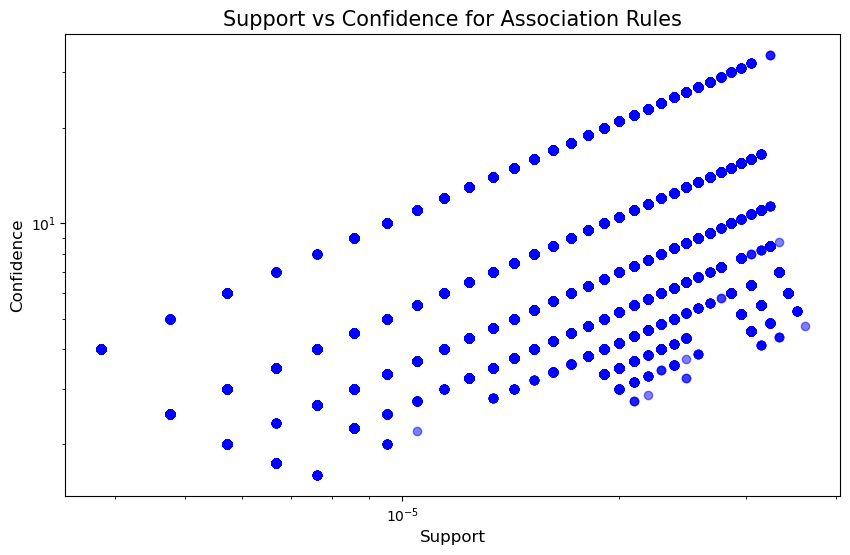

,antecedent_items,consequent_item,lift
1048574,[],Advanced Action Gel Laundry Stain Remover,inf
1038503,[],Ultra This Colby Jack,inf
1038515,[],Synergy Organic & Raw Green Chia Kombucha,inf
1038514,[],Automatic Dishwasher Tablets Citrus - 25 CT,inf
1038513,[],Beyond Chicken Grilled Strips,inf


In [38]:


# Plot a scatter plot of support vs confidence
plt.figure(figsize=(10,6))
plt.scatter(df_rules['support'], df_rules['confidence'], alpha=0.5, color='blue')
plt.title('Support vs Confidence for Association Rules', fontsize=15)
plt.xlabel('Support', fontsize=12)
plt.ylabel('Confidence', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.show()

# Filter for the top 10 strongest associations based on lift
top_pairs = df_rules.sort_values('lift', ascending=False).head(10)

# Display the top pairs and their lift
top_pairs[['antecedent_items', 'consequent_item', 'lift']].head()
